<a href="https://colab.research.google.com/github/t2wain/colab/blob/master/Learn_MNIST_data_set.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import random

# Inspecting data

In [0]:
digits = datasets.load_digits()

In [0]:
print("data:", digits.data.shape, type(digits.data))
print("target:", digits.target.shape, type(digits.target))
print("target_names:", digits.target_names.shape, type(digits.target_names))
print("images:", digits.images.shape, type(digits.images))

data: (1797, 64) <class 'numpy.ndarray'>
target: (1797,) <class 'numpy.ndarray'>
target_names: (10,) <class 'numpy.ndarray'>
images: (1797, 8, 8) <class 'numpy.ndarray'>


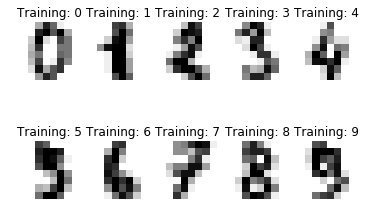

In [0]:
images_and_labels = list(zip(digits.images, digits.target))
for index, (image, label) in enumerate(images_and_labels[:10]):
    plt.subplot(2, 5, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('Training: %i' % label)

# Example 1

## Helper methods

In [0]:
def data_gen(X, Y=None, batch_size=1, epochs=1):
  X_size, _ = X.shape

  for step in range(epochs * X_size // batch_size):
    offset = (step * batch_size) % X_size
    batch_x = X[offset:(offset + batch_size), :]
    batch_y = None if Y is None else Y[offset:(offset + batch_size)]
    yield (batch_x, batch_y)

In [0]:
def build_dnn(num_features, num_labels, hiddens=[]):
  
  def loss(Y, output):
    xentropy = -tf.reduce_sum(Y * tf.log(output), reduction_indices=1)
    loss = tf.reduce_mean(xentropy)
    return loss

  
  xdim = num_features
  Xin = tf.placeholder(tf.float32, shape=[None, num_features])
  Yin = tf.placeholder(tf.float32, shape=[None, num_labels])
  
  X = Xin; W = None; layers = []; out = None
  for idx, ydim in enumerate(hiddens):
    W = tf.Variable(tf.truncated_normal([xdim, ydim], stddev=0.1))
    b = tf.Variable(tf.truncated_normal([ydim], stddev=0.1))
    out = tf.nn.relu6(tf.matmul(X, W) + b)
    layers.append({"W": W, "b": b, "out": out, "W_val": None, "b_val": None})
    X = out
    xdim = ydim
  
  if not out is None:
    layer_drop = tf.nn.dropout(out, rate=0.5)
  
  xdim = num_features if W is None else xdim
  W = tf.Variable(tf.truncated_normal([xdim, num_labels], stddev=0.1))
  b = tf.Variable(tf.truncated_normal([num_labels], stddev=0.1))
  out = tf.nn.softmax(tf.matmul(X, W) + b)
  layers.append({"W": W, "b": b, "out": out, "W_val": None, "b_val": None})
  
  cost = loss(Yin, out)
  correct_prediction = tf.equal(tf.argmax(out, 1), tf.argmax(Yin, 1))
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
  
  return {"x": Xin, "y": Yin, "layers": layers, 
          "cost": cost, "accuracy": accuracy, "out": out}

In [0]:
def build_classifier_estimator(num_features, num_labels, hiddens=[]):
  is_saved = False
  
  dnn = build_dnn(num_features, num_labels, hiddens)
  y_model = dnn["out"]
  cost = dnn["cost"]
  accuracy = dnn["accuracy"]
  X = dnn["x"]
  Y = dnn["y"]

  def train(xsample, ysample,  batch_size=1, training_epochs=1, learning_rate=0.001):
    train_op = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)
    #train_op = tf.train.AdamOptimizer(learning_rate).minimize(cost)
    
    with tf.Session() as sess:
      if is_saved:
        _restoreVars(sess)
      else:
        sess.run(tf.global_variables_initializer())
      for (batch_xs, batch_labels) in data_gen(xsample, ysample,  batch_size, training_epochs):
        err, _ = sess.run([cost, train_op], feed_dict={X: batch_xs, Y: batch_labels})
      _saveVars(sess)

      
  def _restoreVars(sess):
    for layer in dnn["layers"]:
      sess.run(layer["W"].assign(layer["W_val"]))
      sess.run(layer["b"].assign(layer["b_val"]))

    
  def _saveVars(sess):
    is_saved = True
    for layer in dnn["layers"]:
      layer["W_val"] = sess.run(layer["W"])
      layer["b_val"] = sess.run(layer["b"])

      
  def evaluate(xsample, ysample, batch_size=1):
    with tf.Session() as sess:
      _restoreVars(sess)
      cost_total = accuracy_total = step = 0
      for (batch_xs, batch_ys) in data_gen(xsample, ysample,  batch_size):
        cost_val, accuracy_val = sess.run([cost, accuracy], feed_dict={X: batch_xs, Y: batch_ys})
        cost_total += cost_val
        accuracy_total += accuracy_val
        step += 1
      return (cost_val, accuracy_total/step)

    
  def predict(xdata, labels, batch_size=1):
    with tf.Session() as sess:
      _restoreVars(sess)
      res = [];
      for (batch_xs, _) in data_gen(xdata, batch_size=batch_size):
        ydata = sess.run(tf.argmax(y_model, 1), feed_dict={X: batch_xs})
        res.extend(ydata)
      return labels[res]

    
  return (train, evaluate, predict)

In [0]:
def one_hot(labels, ydata):
  y_target = np.expand_dims(ydata, axis=1)
  enc = OneHotEncoder(categories=[labels])
  enc.fit(y_target)
  return (labels, enc.transform(y_target).toarray())

## Example

In [0]:
def ex(nsample=None):
  ds = datasets.load_digits()
  
  batch_size = 128
  learning_rate = 0.0001
  hidden_layers = [512,256,128]
 
  if nsample==None:
    xsample = ds.data
    ysample = ds.target
  else:
    sel_idx = random.sample(range(1, ds.data.shape[0]), nsample)
    xsample = ds.data[sel_idx]
    ysample = ds.target[sel_idx]

  y_labels, y_dummies = one_hot(ds.target_names, ysample)
  
  x_train, x_test, y_train, y_test = train_test_split(
    xsample, y_dummies, test_size=0.3, random_state=42)

  train_size, num_features = x_train.shape
  num_labels = ds.target_names.shape[0]
  
  (_train, _evaluate, _predict) = build_classifier_estimator(
      num_features, num_labels, hidden_layers)


  def train(epochs=300):
    _train(x_train, y_train, batch_size, epochs, learning_rate)


  def eval():
    (cost_val, accuracy_val) = _evaluate(x_train, y_train, batch_size)
    print("Train metric:")
    print({"accuracy": accuracy_val, "loss": cost_val})
    
    (cost_val, accuracy_val) = _evaluate(x_test, y_test, batch_size)
    print("Test metric:")
    print({"accuracy": accuracy_val, "loss": cost_val})


  def predict():
    y_pred = _predict(x_test, ds.target_names, batch_size)
    ydata = y_labels[np.argmax(y_test, axis=1)]
    return np.array(list(zip(ydata, y_pred)))


  return (train, eval, predict)

In [0]:
(ex_train, ex_eval, ex_predict) = ex()

In [8]:
ex_train(1000)
ex_eval()

Train metric:
{'accuracy': 0.9852430555555556, 'loss': 0.17254516}
Test metric:
{'accuracy': 0.94921875, 'loss': 0.21186855}


In [0]:
ex_predict()